# **Robustness against disorder of extended SSH Bound States**
In this notebook, we present the code we used for analysing the effects of disorder in the extended SSH Bound States, seeking to compare its topological features to a model of coupled cavities array (CCA) with staggered potentials, that despite having a symmetric spectrum, is topologically trivial. 

We will start by importing 

In [7]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

# Dictionary of hopping amplitudes in different topological phases, all
# reproducing the same band-gap width of E_g /J = 0.21
winding_to_hoppings = {'-1': (1,1,0.8,0.5), '1':(1,1,0.5,0.5-0.2339),
                    '2': (1,1,0.5,0.8), '0': (1,1,0.5-0.2339,0.5)}

We will start by defining the functions that will diagonalize the extended SSH and CCA models with a quantum emitter locally coupled in the center of the lattice, and extract their respective bound state wavefunctions.

In [8]:
def diagonalize_extended_ssh_hamiltonian(hoppings, g, Delta, N_cells, sigma, dis):
    
    """
    Returns the spectrum and eigenstates of the extended SSH bath hamiltonian
    with a lattice size od 2*N_cells, and gaussian disorder that either 
    preserves or break chiral symmetry (depending of the 'dis' argument) and
    a disorder strength sigma.
    
    The QE is coupled at a detuning Delta.
    """

    # Retrieve hoppings from list
    t1, t2, r1, r2 = hoppings
    
    # We start by builing the bath hamiltonian
    
    M = 2*N_cells
    H = np.zeros( (M+1, M+1) )
    H_b = np.zeros( (M, M) )
    
    for i in range(M-3):
        
        if i%2 == 0:
        
            H_b[i, i+1] = t1 
            H_b[i, i+3] = r1 
            
            # Add disorder, depending on if it preserves chiral symmetry
            # or not. 
            
            if dis == 'preserving':
               # Symmetry-preserving case: disorder odd-hoppings
               H_b[i, i+1] += sigma*np.random.randn()
               H_b[i, i+3] += sigma*np.random.randn()
               
            if dis == 'breaking':
               # Symmetry-breaking case: disorder diagonal/even hoppings
               H_b[i, i] += sigma*np.random.randn()
               H_b[i, i+2] += sigma*np.random.randn()
            
            # Impose hermiticity
            H_b[i+1, i], H_b[i+3, i] = H_b[i, i+1], H_b[i, i+3]
            H_b[i+2,i] = H_b[i, i+2]
            
        else:
            
            H_b[i, i+1] = t2
            H_b[i, i+3] = r2
            
            if dis == 'preserving':
               H_b[i, i+1] += sigma*np.random.randn()
               H_b[i, i+3] += sigma*np.random.randn()
               
            if dis == 'breaking':
               H_b[i, i] += sigma*np.random.randn()
               H_b[i, i+2] += sigma*np.random.randn()
            
            # Impose hermiticity
            H_b[i+1, i], H_b[i+3, i] = H_b[i, i+1], H_b[i, i+3]
            H_b[i+2,i] = H_b[i, i+2]
            
    # Regarding the right edge:
    
    H_b[M-3, M-2] = t2 + sigma*np.random.randn() 
    H_b[M-2, M-1] = t1 + sigma*np.random.randn()
    H_b[M-2, M-3], H_b[M-1, M-2] = H_b[M-3, M-2], H_b[M-2, M-1]

    # Coupling the emitter in the first dimension of the hamiltonian
    em = np.zeros((M+1))
    em[0] = Delta
    em[N_cells-1] = g
    H[0, :], H[:, 0] = em, em
    H[1:, 1:] = H_b
    
    # Diagonalizing the hamiltonian
    omega, C = LA.eigh(H)

    return omega, C

def diagonalize_standard_waveguide_hamiltonian(delta, g, Delta, N_cells, sigma, dis):

    """    
     This function takes a finite CCA with N_cells cells, and
     couples a emitter to site A of cell 0. Returns the eigenvalues and 
     eigenstates of the finite hamiltonian, from where we aim to extract the 
     photonic bound state coefficients
    """
    # We start by builing the bath hamiltonian
    
    M = 2*N_cells
    H = np.zeros( (M+1, M+1) )
    H_b = np.zeros( (M, M) )
    
    for i in range(M-3):
        
        if i%2 == 0: H_b[i, i] = delta
        else: H_b[i, i] = -delta
        
        H_b[i, i+1] = 1
            
        # Add disorder, depending on if it preserves chiral symmetry
        # or not. 
            
        if dis == 'preserving':
        # Symmetry-preserving case: disorder odd-hoppings
            H_b[i, i+1] += sigma*np.random.randn()
            H_b[i, i+3] += sigma*np.random.randn()
               
        if dis == 'breaking':
        # Symmetry-breaking case: disorder diagonal/even hoppings
            H_b[i, i] += sigma*np.random.randn()
            H_b[i, i+2] += sigma*np.random.randn()
            
        # Impose hermiticity
        H_b[i+1, i], H_b[i+3, i] = H_b[i, i+1], H_b[i, i+3]
        H_b[i+2,i] = H_b[i, i+2]
            
        
            
    # Regarding the right edge:
    
    H_b[M-3, M-2] = 1 + sigma*np.random.randn() 
    H_b[M-2, M-1] = 1 + sigma*np.random.randn()
    H_b[M-2, M-3], H_b[M-1, M-2] = H_b[M-3, M-2], H_b[M-2, M-1]
    H_b[M-3, M-3] = -delta
    H_b[M-2, M-2] = delta
    H_b[M-1,M-1] = -delta
    

    em = np.zeros((M+1))
    em[0] = Delta
    em[N_cells-1] = g               # Emitter coupled at the crystal bulk
    H[0, :], H[:, 0] = em, em
    H[1:, 1:] = H_b

    omega, C = LA.eigh(H)

    return omega, C

We will now write functions that will take (for each model) a sample of realizations of disorder, and will later compute the mean and variance of the bound state energies. Robustness against symmetry-preserving disorder is expected to manifest as (i) a lower value for the variance in the topological case and (ii) a scaling in $g$ only for the CCA model variance.

In [9]:
def disordered_bound_state_energies_extended_SSH(winding, g, Delta, N_cells, dis, n_sample):
    """
    This function takes a set of disorder strengths and, for each value,
    computes a sample of bound state energies. Returns a batch of mean and
    standard deviation of energy samples.
    """
    # Define disorder strengths to test
    sigmas = np.linspace(0, 0.1, 30)

    # Retrieve hoppings from dictionary
    hoppings = winding_to_hoppings[str(winding)]

    # Initialize
    mean, std = np.array([]), np.array([])
    
    # Swipe all different values of disorder strength
    for sigma in sigmas:
        
        # For fixed w, fill array with length values
        energy = np.zeros((n_sample))
        
        for i in range(n_sample):
            omega, C = diagonalize_extended_ssh_hamiltonian(hoppings, g, Delta, 
                                                            N_cells, sigma, dis)
            
            K = np.argmax(np.abs(C[0,:]**2))
            energy[i] = omega[K]
        
        # Append mean and std of overlap values    
        mean = np.append(mean, np.mean(energy))
        std = np.append(std, np.std(energy))
        
    return mean, std

# Standard Waveguide model

def disordered_bound_state_energies_standard_waveguide(delta, g, Delta, N_cells, dis, n_sample):
    # Define disorder strengths to test
    sigmas = np.linspace(0, 0.1, 30)
    
    # Initialize
    mean, std = np.array([]), np.array([])
    
    # Swipe all different values of disorder strength
    for sigma in sigmas:
        
        # For fixed w, fill array with length values
        energy = np.zeros((n_sample))
        
        for i in range(n_sample):
            omega, C = diagonalize_standard_waveguide_hamiltonian(delta, g, 
                                                                  Delta, N_cells, 
                                                                  sigma, dis)
            
            K = np.argmax(np.abs(C[0,:]**2))
            energy[i] = omega[K]
            
        # Append mean and std of overlap values    
        mean = np.append(mean, np.mean(energy))
        std = np.append(std, np.std(energy))
        
    return mean, std

We will now obtain a graphical representation of energy robustness of topological bound states, by computing sample means and variances within both models and plotting them for increasing disorder strength.

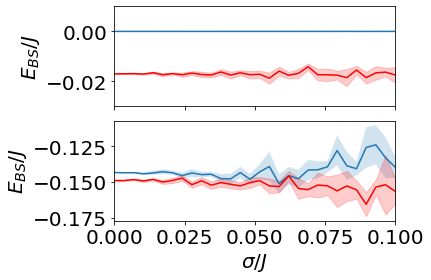

In [11]:

mean_middle, std_middle = disordered_bound_state_energies_extended_SSH(2, 0.2, 0, 300, 
                                              'preserving', 10)
mean_lower, std_lower = disordered_bound_state_energies_extended_SSH(2, 0.2, -3.3, 300, 
                                              'preserving', 10)
mean_delta, std_delta = disordered_bound_state_energies_standard_waveguide(0.212/2, 0.2, 0, 300,
                                                'preserving', 10)
mean_delta_lower, std_delta_lower = disordered_bound_state_energies_standard_waveguide(0.212/2, 0.2, -2.1, 300,
                                                'preserving', 10)

# Set the reference energy
mean_lower = mean_lower + 3.2
mean_delta_lower = mean_delta_lower + 2

# Compute mean energies and plot for 10 samples
fig, axes = plt.subplots(nrows=2, sharex=True)
ws = np.linspace(0, 0.1, 30)

axes[0].plot(ws, mean_middle)
axes[0].fill_between(ws, mean_middle+std_middle/2, mean_middle-std_middle/2,
                     alpha=0.2)
axes[0].plot(ws, mean_delta, color='red')
axes[0].fill_between(ws, mean_delta+std_delta/2, mean_delta-std_delta/2,
                     alpha=0.2, color='red')
axes[1].plot(ws, mean_lower)
axes[1].fill_between(ws, mean_lower+std_lower/2, mean_lower-std_lower/2,
                     alpha=0.2)
axes[1].plot(ws, mean_delta_lower, color='red')
axes[1].fill_between(ws, mean_delta_lower+std_delta_lower/2, 
                     mean_delta_lower-std_delta_lower/2,
                     alpha=0.2, color='red')

axes[1].set_xlabel('$\sigma/J$', fontsize=20)
axes[0].set_ylabel('$E_{BS}/J$', fontsize=20)
axes[1].set_ylabel('$E_{BS}/J$', fontsize=20)
axes[0].set_ylim([-0.03, 0.01])
axes[0].set_xlim([0, 0.1])
axes[1].set_xlim([0, 0.1])
plt.tight_layout()

We can proceed similarly and plot the variances for different values of the coupling constant $g$.

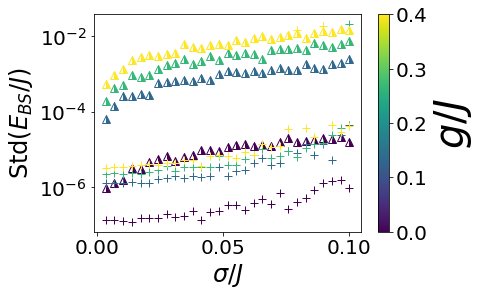

In [ ]:
fig, ax = plt.subplots()

gs = [0.01, 0.1, 0.2, 0.4]
N_cells = 300
gap = 0.2123
norm = Normalize(vmin=0, vmax= 3)
cmap = cm.viridis
sigmas = np.linspace(0, 0.1, 30)
delta = 0.212/2

n_sample = 30

for (i, g) in enumerate(gs):
    
    # Compute energies and variances
    mean_r, std_r = disordered_bound_state_energies_extended_SSH(2, g, 0, N_cells, 'preserving', 
                                        n_sample)
                                        
    mean, std = disordered_bound_state_energies_standard_waveguide(delta, g, 0, N_cells, 
                                        'preserving', n_sample)
                                        
    # Plot the results
    ax.plot(sigmas[1:], std_r[1:], '+', c=cmap(norm(i)), markersize=8)
    ax.plot(sigmas[1:], std[1:], '^', c=cmap(norm(i)), markersize=8,
            fillstyle='right')
    
norm = Normalize(vmin=0, vmax=0.4)    
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('$g/J$', fontsize = 40)
ax.set_xlabel('$\sigma/J$', fontsize=24)
ax.set_ylabel('Std$(E_{BS}/J)$', fontsize = 24)
ax.set_yscale('log')